In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from shallow_fbcsp import ShallowFBCSPNet
import pandas as pd
from collections import OrderedDict
import math

In [2]:
def linear_kernel(X):
    """Computes the linear kernel matrix for X."""
    return torch.matmul(X,X.T)  # Dot product

def centering_matrix(K):
    """Apply centering to the kernel matrix."""
    n = K.shape[0]
    H = torch.eye(n) - (1.0 / n) * torch.ones((n, n), device=K.device)
    return H @ K @ H  # Centered kernel matrix

def compute_hsic(K_x, K_y):
    """
    Computes the Hilbert-Schmidt Independence Criterion (HSIC).
    
    Parameters:
    - X: (n_samples, n_features_X) numpy array
    - Y: (n_samples, n_features_Y) numpy array
    - kernel_X: function to compute the kernel matrix for X
    - kernel_Y: function to compute the kernel matrix for Y
    
    Returns:
    - HSIC value (float)
    """
    K_x_centered = centering_matrix(K_x)
    K_y_centered = centering_matrix(K_y)
    hsic_value = np.trace(K_x_centered @ K_y_centered) / ((K_x.shape[0] - 1) ** 2)
    return hsic_value
  
def compute_CKA(K_x,K_y):
  """
  compute CKA between two X,Y activations
  
  Parameters:
  - X: (n_samples, x_features)
  - Y: (n_samples, y_features)
  - kernel_X: kernel for X
  - kernel_Y: kernel for Y  
  """
  HSIC_KL = compute_hsic(K_x,K_y) 
  HSIC_KK = compute_hsic(K_x,K_x)
  HSIC_LL = compute_hsic(K_y,K_y)
  numerator = HSIC_KL
  denominator = math.sqrt(HSIC_KK * HSIC_LL)
  return(numerator/denominator).item()


In [3]:
# Define model parameters
in_chans = 22
n_classes = 4
n_channels = 22
input_window_samples = 1125
# Load two models for comparison
model= torch.load("braindecode_model_temponly_1.pth",weights_only = False,map_location=torch.device('cpu'))
model2 =torch.load("conformer_model.pth",weights_only = False,map_location=torch.device('cpu'))#ShallowFBCSPNet(in_chans, n_classes, input_window_samples)



In [4]:
print(model2)

Layer (type (var_name):depth-idx)                            Input Shape               Output Shape              Param #                   Kernel Shape
EEGConformer (EEGConformer)                                  [1, 22, 1000]             [1, 4]                    --                        --
├─_PatchEmbedding (patch_embedding): 1-1                     [1, 1, 22, 1000]          [1, 61, 40]               --                        --
│    └─Sequential (shallownet): 2-1                          [1, 1, 22, 1000]          [1, 40, 1, 61]            --                        --
│    │    └─Conv2d (0): 3-1                                  [1, 1, 22, 1000]          [1, 40, 22, 976]          1,040                     [1, 25]
│    │    └─Conv2d (1): 3-2                                  [1, 40, 22, 976]          [1, 40, 1, 976]           35,240                    [22, 1]
│    │    └─BatchNorm2d (2): 3-3                             [1, 40, 1, 976]           [1, 40, 1, 976]           80             

In [5]:
print(model)

Layer (type (var_name):depth-idx)        Input Shape               Output Shape              Param #                   Kernel Shape
ShallowFBCSPNet (ShallowFBCSPNet)        [1, 22, 1125]             [1, 4]                    --                        --
├─SafeLog (pool_nonlin_exp): 1-1         [1, 22, 1125]             [1, 22, 1125]             --                        --
├─Ensure4d (ensuredims): 1-2             [1, 22, 1125]             [1, 22, 1125, 1]          --                        --
├─Rearrange (dimshuffle): 1-3            [1, 22, 1125, 1]          [1, 1, 1125, 22]          --                        --
├─Conv2d (conv_time): 1-4                [1, 1, 1125, 22]          [1, 40, 1101, 22]         1,040                     [25, 1]
├─Conv2d (conv_spat): 1-5                [1, 40, 1101, 22]         [1, 40, 1101, 1]          35,200                    [1, 22]
├─BatchNorm2d (bnorm): 1-6               [1, 40, 1101, 1]          [1, 40, 1101, 1]          80                        --
├─Ex

In [12]:
import os
import torch

def extract_model_activations(model, input_tensor, output_dir, batch_size=128):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    activations = OrderedDict()

    def get_activation(name):
        def hook(model, input, output):
            activations[name] = output.detach()
        return hook

    # Register hooks for specific layers
    for name, layer in model.named_modules():
        if name == "conv_time" or name == "conv_spat" or name =="pool" or name == "patch_embedding.shallownet.0" or  name == "patch_embedding.shallownet.1" or  name == "patch_embedding.shallownet.4" :  # Modify as per your layer names
            layer.register_forward_hook(get_activation(name))

    model.eval()

    with torch.no_grad():
        for i in range(0, input_tensor.shape[0], batch_size):
            batch = input_tensor[i:i + batch_size]  # Select current batch
            _ = model(batch)  # Forward pass through the model

            # Save activations after each batch
            for name, activation in activations.items():
                batch_idx = i // batch_size + 1  # This determines the batch number
                print(f"saving: {name}_batch_{batch_idx}.pt")
                torch.save(activation, os.path.join(output_dir, f"{name}_batch_{batch_idx}.pt"))
            
            # Clear activations list after saving
            activations.clear()
            torch.cuda.empty_cache()  # Optional: Clear GPU memory after each batch



In [13]:
import pickle
with open('Datasets/test_set.pkl', 'rb') as f:
    test_set = pickle.load(f)

In [14]:
X = torch.stack([torch.from_numpy(test_set[i][0]) for i in range(len(test_set))])

total_samples = X.shape[0]
print(X.shape)  # Verify the tensor shape
print(type(X))  # Should output <class 'torch.Tensor'>


torch.Size([2592, 22, 1125])
<class 'torch.Tensor'>


In [15]:
print(model.conv_time.weight.device)  # Check the device of the conv_time layer
print(next(model.parameters()).device)


cpu
cpu


In [16]:

batch_size = 128
total_samples = X.shape[0]
print(total_samples)

2592


In [17]:
extract_model_activations(model,X,output_dir="Datasets/activations/model1/",batch_size=batch_size)


saving: conv_time_batch_1.pt
saving: conv_spat_batch_1.pt
saving: pool_batch_1.pt
saving: conv_time_batch_2.pt
saving: conv_spat_batch_2.pt
saving: pool_batch_2.pt
saving: conv_time_batch_3.pt
saving: conv_spat_batch_3.pt
saving: pool_batch_3.pt
saving: conv_time_batch_4.pt
saving: conv_spat_batch_4.pt
saving: pool_batch_4.pt
saving: conv_time_batch_5.pt
saving: conv_spat_batch_5.pt
saving: pool_batch_5.pt
saving: conv_time_batch_6.pt
saving: conv_spat_batch_6.pt
saving: pool_batch_6.pt
saving: conv_time_batch_7.pt
saving: conv_spat_batch_7.pt
saving: pool_batch_7.pt
saving: conv_time_batch_8.pt
saving: conv_spat_batch_8.pt
saving: pool_batch_8.pt
saving: conv_time_batch_9.pt
saving: conv_spat_batch_9.pt
saving: pool_batch_9.pt
saving: conv_time_batch_10.pt
saving: conv_spat_batch_10.pt
saving: pool_batch_10.pt
saving: conv_time_batch_11.pt
saving: conv_spat_batch_11.pt
saving: pool_batch_11.pt
saving: conv_time_batch_12.pt
saving: conv_spat_batch_12.pt
saving: pool_batch_12.pt
saving:

In [22]:
from scipy.signal import resample
resampled_input = torch.from_numpy(resample(X, num=1000, axis=-1))
resampled_input

tensor([[[ 0.7572,  0.2350, -0.6641,  ..., -0.5319, -0.7245, -0.7503],
         [ 0.9262,  0.3819, -0.6817,  ..., -0.1393, -0.6566, -1.0515],
         [ 0.7173,  0.1305, -0.8557,  ..., -0.5107, -0.9155, -1.1805],
         ...,
         [ 1.0485,  0.3779, -0.4664,  ...,  0.3598, -0.3712, -1.1172],
         [ 1.2797,  0.5733, -0.3778,  ...,  0.2856, -0.4021, -1.0165],
         [ 0.8957,  0.2404, -0.4676,  ...,  0.4036, -0.2375, -0.9484]],

        [[-0.9802, -0.4504,  0.0736,  ...,  0.3706,  0.5285,  0.3389],
         [-1.4601, -1.0182, -0.3219,  ..., -0.1469,  0.0648, -0.0264],
         [-1.1477, -0.5098,  0.1589,  ..., -0.0585,  0.2614,  0.2788],
         ...,
         [-0.4758,  0.5283,  1.1812,  ...,  0.9263,  1.3226,  1.0898],
         [-0.3593,  0.6378,  1.2573,  ...,  0.9938,  1.5093,  1.3627],
         [-0.5109,  0.2467,  0.6979,  ...,  1.1527,  1.4732,  1.1049]],

        [[ 0.4521,  0.7261,  0.6770,  ..., -0.2889, -0.1052,  0.1011],
         [ 0.2186,  0.4495,  0.5285,  ...,  0

In [23]:
extract_model_activations(model2,resampled_input,output_dir="Datasets/activations/model2/",batch_size=batch_size)

saving: patch_embedding.shallownet.0_batch_1.pt
saving: patch_embedding.shallownet.1_batch_1.pt
saving: patch_embedding.shallownet.4_batch_1.pt
saving: patch_embedding.shallownet.0_batch_2.pt
saving: patch_embedding.shallownet.1_batch_2.pt
saving: patch_embedding.shallownet.4_batch_2.pt
saving: patch_embedding.shallownet.0_batch_3.pt
saving: patch_embedding.shallownet.1_batch_3.pt
saving: patch_embedding.shallownet.4_batch_3.pt
saving: patch_embedding.shallownet.0_batch_4.pt
saving: patch_embedding.shallownet.1_batch_4.pt
saving: patch_embedding.shallownet.4_batch_4.pt
saving: patch_embedding.shallownet.0_batch_5.pt
saving: patch_embedding.shallownet.1_batch_5.pt
saving: patch_embedding.shallownet.4_batch_5.pt
saving: patch_embedding.shallownet.0_batch_6.pt
saving: patch_embedding.shallownet.1_batch_6.pt
saving: patch_embedding.shallownet.4_batch_6.pt
saving: patch_embedding.shallownet.0_batch_7.pt
saving: patch_embedding.shallownet.1_batch_7.pt
saving: patch_embedding.shallownet.4_bat

In [24]:
length = torch.load(f"Datasets/activations/model1/conv_time_batch_{3}.pt")
print(length.shape)

C:\Users\ahmm9\AppData\Local\Temp\ipykernel_11988\4051774759.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  length = torch.load(f"Datasets/activations/model1/conv_time_

torch.Size([128, 40, 1101, 22])


In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import OrderedDict
del X
# Use OrderedDict to preserve the order of layer names
layer_names_model1 = ['conv_time', 'conv_spat','pool']
layer_names_model2 = ["patch_embedding.shallownet.0","patch_embedding.shallownet.1","patch_embedding.shallownet.4"]


print(layer_names_model1)
print(layer_names_model2)

['conv_time', 'conv_spat', 'pool']
['patch_embedding.shallownet.0', 'patch_embedding.shallownet.1', 'patch_embedding.shallownet.4']


In [26]:
import math
batch_nr = total_samples /batch_size

batch_nr

20.25

In [27]:




def compute_kernel_full_highmem(layer, batch_nr, model_number):
    """Computes the linear kernel for all samples at once."""
    

    activations_list = []
    
    for batch_idx in range(1, math.ceil(batch_nr+1)):
        print(f"\rLoading batch {batch_idx} for {layer} in model {model_number}", end='', flush=True)
        

        batch_activations = torch.load(f"Datasets/activations/model{model_number}/{layer}_batch_{batch_idx}.pt")
        batch_activations = batch_activations.reshape(batch_activations.shape[0], -1)  # Flatten
        
        activations_list.append(batch_activations)
    
    all_activations = torch.cat(activations_list, dim=0)
    print("\nFinal Activations Shape:", all_activations.shape)

    full_kernel = torch.matmul(all_activations, all_activations.T)

    return full_kernel

# model_1_kernels = OrderedDict()
# model_2_kernels = OrderedDict()

# for layer in layer_names_model1:
#     model_1_kernels[layer] = compute_kernel_full_highmem(layer, batch_nr,1)
# for layer in layer_names_model2:
#     model_2_kernels[layer] = compute_kernel_full_highmem(layer,batch_nr,2)







In [29]:
def compute_kernel_full_lowmem(layer, batch_nr, model_number, total_samples, batch_size, n_batches=1, use_cuda=False):
    """Computes the full kernel matrix in batches efficiently using matrix multiplication."""
    
    device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")

    full_kernel = torch.zeros((total_samples, total_samples), dtype=torch.float32, device=device)
    
    for batch_idx in range(1, math.ceil(math.ceil(batch_nr) / n_batches) + 1):
        print(f"\rLoading batches {batch_idx * n_batches - (n_batches - 1)}-{batch_idx * n_batches} for {layer} in model {model_number}", 
              end='', flush=True)

        batch_activations_list = []
        start_idx_col = (batch_idx - 1) * batch_size * n_batches
        end_idx_col = min(start_idx_col + batch_size * n_batches, total_samples)  

        # Load multiple batches at once
        for sub_batch in range(n_batches):
            batch_file_idx = (batch_idx - 1) * n_batches + sub_batch + 1
            if batch_file_idx > math.ceil(batch_nr):
                break
            batch_activations = torch.load(
                f"Datasets/activations/model{model_number}/{layer}_batch_{batch_file_idx}.pt"
            ).to(device)
            batch_activations_list.append(batch_activations.reshape(batch_activations.shape[0], -1))

        if not batch_activations_list:
            continue

        batch_activations = torch.cat(batch_activations_list, dim=0)  # Merge batches

        for batch_idx2 in range(1, math.ceil(math.ceil(batch_nr) / n_batches) + 2):
            batch_activations_transpose_list = []
            start_idx_row = (batch_idx2 - 1) * batch_size * n_batches
            end_idx_row = min(start_idx_row + batch_size * n_batches, total_samples)

            # Load multiple batches at once
            for sub_batch2 in range(n_batches):
                batch_file_idx2 = (batch_idx2 - 1) * n_batches + sub_batch2 + 1
                if batch_file_idx2 > math.ceil(batch_nr):
                    break
                batch_activations_transpose = torch.load(
                    f"Datasets/activations/model{model_number}/{layer}_batch_{batch_file_idx2}.pt"
                ).to(device)
                batch_activations_transpose_list.append(batch_activations_transpose.reshape(batch_activations_transpose.shape[0], -1))

            if not batch_activations_transpose_list:
                continue

            batch_activations_transpose = torch.cat(batch_activations_transpose_list, dim=0)

            kernel_block = batch_activations @ batch_activations_transpose.T
            full_kernel[start_idx_col:end_idx_col, start_idx_row:end_idx_row] = kernel_block
            full_kernel[start_idx_row:end_idx_row, start_idx_col:end_idx_col] = kernel_block.T  # Use symmetry

    return full_kernel.cpu()


def compute_full_kernels(layer_names_model1, layer_names_model2, batch_nr, total_samples,batch_size,n_batches):
    """Computes the kernels for both models."""
    model_1_kernels = {}
    model_2_kernels = {}

    # Compute kernels for model 1
    for layer in layer_names_model1:
        model_1_kernels[layer] = compute_kernel_full_lowmem(layer, batch_nr, 1, total_samples,batch_size,n_batches)

    # Compute kernels for model 2
    for layer in layer_names_model2:
        model_2_kernels[layer] = compute_kernel_full_lowmem(layer, batch_nr, 2, total_samples,batch_size,n_batches)

    return model_1_kernels, model_2_kernels

model_1_kernels = OrderedDict()
model_2_kernels = OrderedDict()
layer_names_model = layer_names_model1 

    
model_1_kernels, model_2_kernels = compute_full_kernels(layer_names_model1, layer_names_model2, batch_nr,total_samples,batch_size,4)

Loading batches 1-4 for conv_time in model 1

C:\Users\ahmm9\AppData\Local\Temp\ipykernel_11988\3079511491.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  batch_activations = torch.load(
C:\Users\ahmm9\AppData\Loca

Loading batches 21-24 for patch_embedding.shallownet.4 in model 2

In [41]:
model_1_kernels_mean = {
    key: tensor - tensor.mean()
    for key, tensor in model_1_kernels.items()
}

model_2_kernels_mean = {
    key: tensor - tensor.mean()
    for key, tensor in model_2_kernels.items()
}

In [42]:
model_1_kernels_mean

{'conv_time': tensor([[3076525.5000, -113278.2500,  434241.0000,  ...,  -76649.7500,
           -33992.2500, -308219.0000],
         [-113278.2500, 3238203.0000,   93663.2500,  ...,  411449.5000,
            32982.5000,  -27320.5000],
         [ 434241.0000,   93663.2500, 3455234.0000,  ...,  335064.5000,
            41526.0000, -117522.5000],
         ...,
         [ -76649.7500,  411449.5000,  335064.5000,  ..., 3740529.0000,
             3751.2500,  167064.5000],
         [ -33992.2500,   32982.5000,   41526.0000,  ...,    3751.2500,
          3223613.5000,  -59523.2500],
         [-308219.0000,  -27320.5000, -117522.5000,  ...,  167065.0000,
           -59523.2500, 3206920.5000]]),
 'conv_spat': tensor([[ 6.7294e+04, -1.7543e+03,  4.2395e+03,  ..., -3.2868e+02,
          -2.1558e+03, -1.6089e+03],
         [-1.7543e+03,  6.1615e+04,  1.2975e+03,  ...,  3.9466e+03,
          -2.0516e+03, -5.1857e+02],
         [ 4.2395e+03,  1.2975e+03,  6.3833e+04,  ...,  1.2998e+03,
          -2.2

In [43]:

print(model_1_kernels_mean["conv_time"].shape)
if (model_1_kernels_mean["conv_time"] == 0).any():
    print("The tensor contains at least one zero value.")
else:
    print("No zero values in the tensor.")

print(model_1_kernels_mean["pool"])


torch.Size([2592, 2592])
The tensor contains at least one zero value.
tensor([[1351.4543,  578.5671,  528.5127,  ...,   69.8857, 1242.9915,
          987.4031],
        [ 578.5671,  501.5063,  182.0315,  ..., -222.9255,  823.1741,
          559.1951],
        [ 528.5127,  182.0315,  470.2117,  ..., -227.2434,  731.7986,
          544.4939],
        ...,
        [  69.8857, -222.9255, -227.2434,  ..., -227.9197,  372.6099,
          100.8899],
        [1242.9915,  823.1741,  731.7986,  ...,  372.6101, 2374.9417,
         1304.4695],
        [ 987.4031,  559.1951,  544.4939,  ...,  100.8899, 1304.4695,
         1609.5051]])


In [44]:
model_2_kernels_mean

{'patch_embedding.shallownet.0': tensor([[276718.6875, -12260.5156,  36394.1562,  ..., -26344.1953,
            4056.9766, -21161.0547],
         [-12260.5156, 283754.7812,   4837.2402,  ...,   7366.8066,
            5317.5234,  16137.7695],
         [ 36394.1562,   4837.2402, 245235.0156,  ..., -10684.3877,
           -5757.5122, -16849.0723],
         ...,
         [-26344.1953,   7366.8066, -10684.3877,  ..., 220753.7812,
          -16346.6689,  10344.8535],
         [  4056.9766,   5317.5234,  -5757.5122,  ..., -16346.6699,
          216353.1562,   3918.3242],
         [-21161.0547,  16137.7695, -16849.0723,  ...,  10344.8535,
            3918.3242, 241446.7500]]),
 'patch_embedding.shallownet.1': tensor([[50103.6211, -2990.6436,  2839.2119,  ...,  -961.6953,  2414.9897,
           -566.7386],
         [-2990.6436, 43966.4453,  1339.3416,  ...,   997.7467, -3688.4561,
            478.9615],
         [ 2839.2119,  1339.3416, 28569.9492,  ...,  -489.7380,   203.9644,
            195.

In [46]:

print(model_2_kernels_mean["patch_embedding.shallownet.4"].shape)
if (model_2_kernels_mean["patch_embedding.shallownet.4"] == 0).any():
    print("The tensor contains at least one zero value.")
else:
    print("No zero values in the tensor.")

print(model_2_kernels_mean["patch_embedding.shallownet.4"])

torch.Size([2592, 2592])
No zero values in the tensor.
tensor([[100.8313,  39.7971,   3.3115,  ...,  -3.0215,  64.8369,  64.3049],
        [ 39.7971,  50.4434,  -2.8465,  ...,  -9.0382,  45.5757,  28.8620],
        [  3.3115,  -2.8465,  -2.4687,  ..., -21.7326,  -0.6643,  -5.3539],
        ...,
        [ -3.0215,  -9.0382, -21.7326,  ...,  -0.4812,  -4.8660,  -8.0428],
        [ 64.8369,  45.5757,  -0.6643,  ...,  -4.8660, 131.0768,  67.7696],
        [ 64.3049,  28.8620,  -5.3539,  ...,  -8.0428,  67.7696, 103.2005]])


In [48]:
cka_results = OrderedDict()

for layer1, K_x in model_1_kernels_mean.items():
    for layer2, K_y in model_2_kernels_mean.items():
        cka_value = compute_CKA(K_x, K_y)
        cka_results[(layer1, layer2)] = cka_value
        print(f"CKA({layer1}, {layer2}): {cka_value}")

CKA(conv_time, patch_embedding.shallownet.0): 0.8394258554049755
CKA(conv_time, patch_embedding.shallownet.1): 0.69623316427972
CKA(conv_time, patch_embedding.shallownet.4): 0.09120927303860057
CKA(conv_spat, patch_embedding.shallownet.0): 0.7112966135392372
CKA(conv_spat, patch_embedding.shallownet.1): 0.7529259560777435
CKA(conv_spat, patch_embedding.shallownet.4): 0.11105491941066073
CKA(pool, patch_embedding.shallownet.0): 0.06266716745604835
CKA(pool, patch_embedding.shallownet.1): 0.07871995395345727
CKA(pool, patch_embedding.shallownet.4): 0.6141148956213193


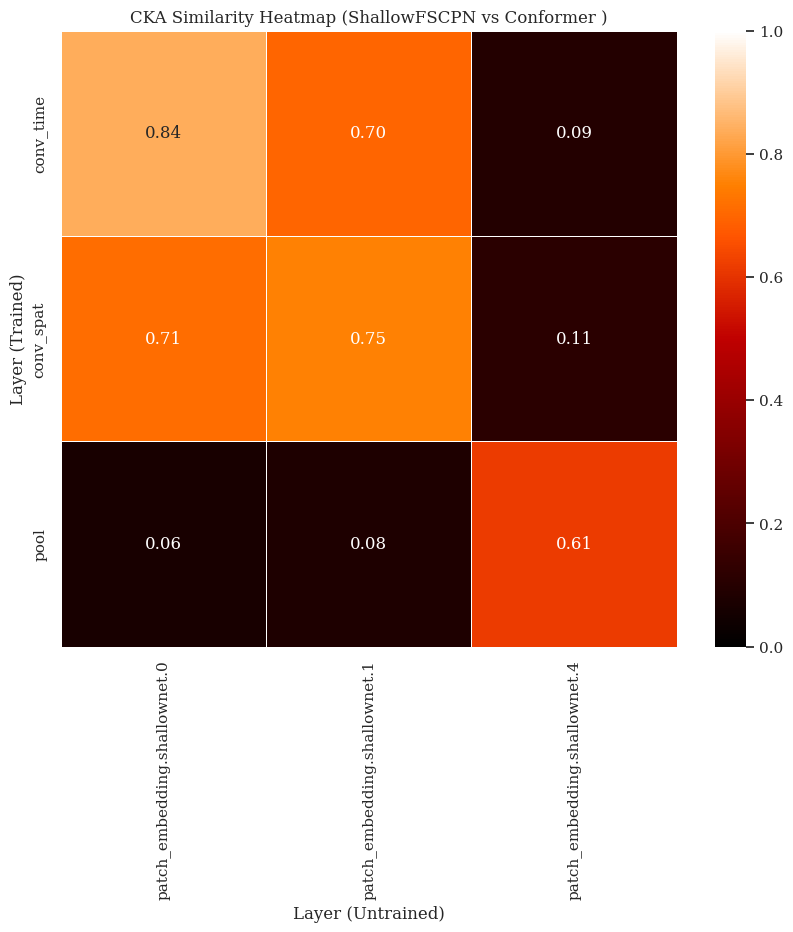

In [50]:
# Initialize a matrix for the CKA similarities
n_layers1 = len(layer_names_model1)
n_layers2 = len(layer_names_model2)
matrix = np.zeros((n_layers1, n_layers2))

# Fill the matrix with the CKA similarity values
for (layer1, layer2), similarity in cka_results.items():
    # Get the index for layer1 in model1 and layer2 in model2
    if layer1 in layer_names_model1:
        i = layer_names_model1.index(layer1)  # Index for model 1 layer
    else:
        i = -1  # Invalid index (in case of layer not in model1)

    if layer2 in layer_names_model2:
        j = layer_names_model2.index(layer2)  # Index for model 2 layer
    else:
        j = -1  # Invalid index (in case of layer not in model2)
    
    if i != -1 and j != -1:  # Only fill the matrix if both indices are valid
        matrix[i, j] = similarity

# Create a DataFrame for better visualization
df = pd.DataFrame(matrix, index=layer_names_model1, columns=layer_names_model2)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df, annot=True, cmap='gist_heat', fmt='.2f', square=True, linewidths=0.5, cbar=True, vmin=0, vmax=1)
plt.title('CKA Similarity Heatmap (ShallowFSCPN vs Conformer )')
plt.xlabel(f'Layer (Untrained)')
plt.ylabel(f'Layer (Trained)')
plt.show()
